# Generate BRN Events

This is the new version of the BRN event generation compared to BRNSpectrum.ipynb, incorporating the discussion with the COHERENT collaboration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Energy distribution

Follow the power law with $\alpha$ = 1.5, according to the approximation from Rebecca's thesis

In [2]:
def power_law_random(alpha, xmin = 1.0, xmax = 100.0, size = 1000):
    """
    Generate random numbers from p(x) ~ x^(-alpha) in [xmin, xmax]
    """
    U = np.random.rand(size)

    if alpha == 1.0:
        # special case: p(x) ~ 1/x
        return xmin * (xmax/xmin) ** U
    else:
        a = 1.0 - alpha
        return ( (U * (xmax**a - xmin**a)) + xmin**a ) ** (1.0/a)


In [3]:
alpha = 1.5
KEmin = 0.5
KEmax = 400.
nSamples = 500000

In [4]:
KE = power_law_random(alpha, KEmin, KEmax, nSamples)
KE

array([  0.64603926,   0.87193877,   1.76505837, ...,   0.98060075,
       129.68646366,   6.13727459])

## Validation

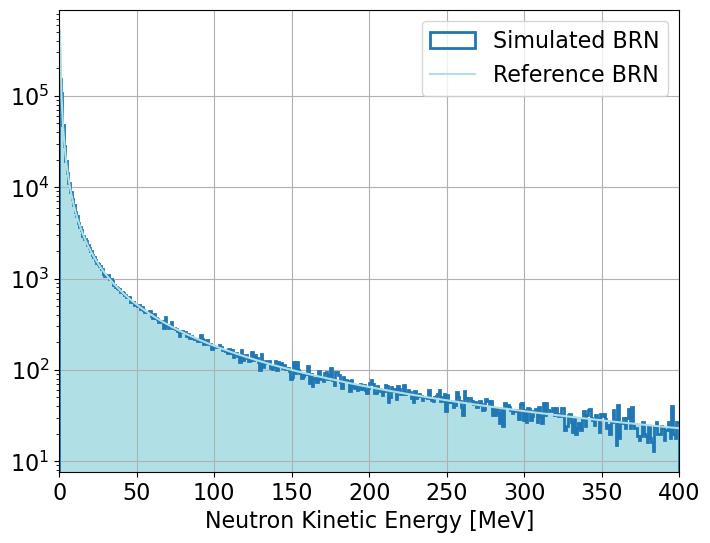

In [5]:
fig, ax = plt.subplots( figsize = (8, 6) )  

A = (-alpha+1)/(KEmax**(-alpha+1)-KEmin**(-alpha+1))
x = np.linspace(KEmin, KEmax, 401)
f = nSamples*A*(x**-alpha)

ax.hist(KE, bins = np.linspace(0, KEmax, 401), histtype = 'step', lw = 2, label = 'Simulated BRN')
ax.plot(x, f, color = 'powderblue', label = 'Reference BRN')
ax.fill_between(x, f, color = 'powderblue')
ax.set_xlabel( 'Neutron Kinetic Energy [MeV]', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xlim( [0, 400])
ax.semilogy()
ax.grid(':')
ax.legend( fontsize = 16)
fig.savefig('BRNPowerLawSpectrum.pdf')

## Generate the location and time: xyzt

In [6]:
def getNSamples(xmin, xmax, N):
    return rng.uniform(xmin, xmax, N)

In [7]:
def isAccepted(n, vPDF, maxPDF):
    return rng.uniform(0., maxPDF, n) < vPDF

In [8]:
def rejectSampling(PDF, tmin, tmax, nSamples):
    outSamples = getNSamples(tmin, tmax, nSamples)
    outSampleBins = np.floor(outSamples/10).astype(int)
    outPDF = PDF[outSampleBins]
    maxPDF = PDF.max()

    mask = isAccepted(len(outSamples), outPDF, maxPDF)
    reject, = np.where(~mask)

    while reject.size > 0:
        fill = getNSamples(tmin, tmax, reject.size)
        fillBins = np.floor(fill/10).astype(int)
        
        fillPDF = PDF[fillBins]
        mask = isAccepted(len(fill), fillPDF, maxPDF)
        outSamples[reject[mask]] = fill[mask]
        reject = reject[~mask]

    return outSamples

In [9]:
# location and time in [cm, ns]
# currently only support one cosmic ray in each event
xloc = -54.
ylim = 50.
zlim = 60.

In [10]:
nTime = np.load('../../../SNS/PromptNeutrinosPer10ns.npy')
nTime.max()

26.170125884924325

In [11]:
rng = np.random.default_rng()
xyzt = np.array([ [ x, y, z, t ] 
                      for x, y, z, t in zip(np.full(nSamples, xloc), 
                                            rng.uniform(-ylim, ylim, nSamples),
                                            rng.uniform(-zlim, zlim, nSamples),
                                            rejectSampling(nTime, 0., 15000., nSamples)) ])
xyzt

array([[-54.        ,  43.23409813, -57.70538473, 398.76907741],
       [-54.        , -45.11271731,  22.39730445, 491.82033613],
       [-54.        ,   9.59051792,  -6.64817488, 670.85686383],
       ...,
       [-54.        , -32.51249542, -56.39162688, 304.6129698 ],
       [-54.        , -29.53182231, -17.9008703 , 390.27408013],
       [-54.        ,  29.41304614,  45.71112172, 547.40301444]])

(0.0, 5.0)

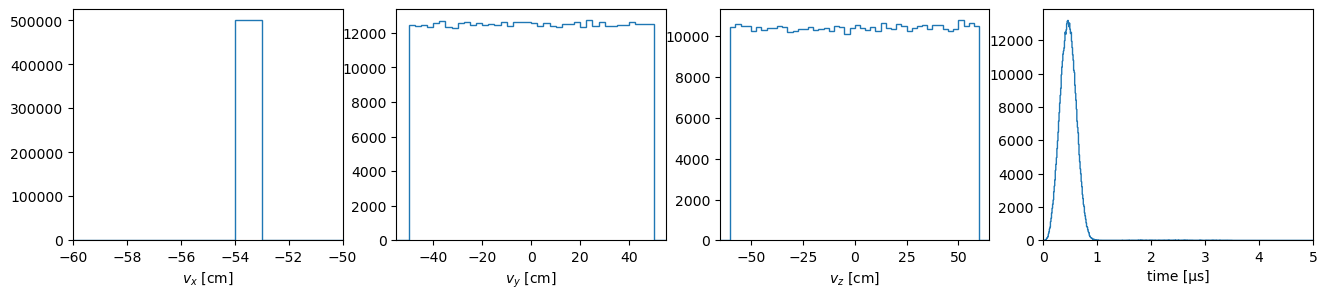

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (16, 3) )

ax[0].hist(xyzt[:,0], bins = np.linspace(-60, -50, 11), histtype = 'step')
ax[0].set_xlabel(r'$v_x$ [cm]')
ax[0].set_xlim( [-60, -50] )

ax[1].hist(xyzt[:,1], bins = np.linspace(-55, 55, 45), histtype = 'step')
ax[1].set_xlabel(r'$v_y$ [cm]')
ax[1].set_xlim( [-55, 55] )

ax[2].hist(xyzt[:,2], bins = np.linspace(-65, 65, 53), histtype = 'step')
ax[2].set_xlabel(r'$v_z$ [cm]')
ax[2].set_xlim( [-65, 65] )

ax[3].hist(xyzt[:,3]/1000, bins = np.linspace( 0, 15, 1501), histtype = 'step')
ax[3].set_xlabel('time [µs]')
ax[3].set_xlim( [0, 5])

## Fill the output HEPEVT file

The output format is compatible with the HEPEVT reader of edep-sim: https://github.com/ClarkMcGrew/edep-sim/blob/master/src/kinem/EDepSimHEPEVTKinematicsGenerator.cc

In [13]:
import os
outdir = '/Users/yuntse/data/coherent/SNeNDSens/gen/BRN'

if os.path.exists(outdir):
    raise FileExistsError(f"Directory '{outdir}' already exists!")
else:
    os.makedirs(outdir)

In [14]:
nPdg = 2112
# unit: GeV
nMass = 0.9395654205
vtxID = 0
nParticlePerVtx = 1

In [15]:
nEventPerFile = 10000
nFiles = int(nSamples/nEventPerFile)
nFiles

50

In [16]:
for iFile in range(nFiles):
    outFile = f'{outdir}/BRN_{iFile:04d}.hepevt'

    with open( outFile, 'w') as f:
        for iEvtPerFile in range(nEventPerFile):
            iEvt = iFile*nEventPerFile + iEvtPerFile

            f.write( f'{iEvt} {vtxID} {nParticlePerVtx}\n')
    
            # ISTHEP IDHEP JMOHEP1 JMOHEP2 JDAHEP1 JDAHEP2 PHEP1 PHEP2 PHEP3 PHEP4 PHEP5 VHEP1 VHEP2 VHEP3 VHEP4
            # final-state particle
            ISTHEP = 1
            IDHEP = nPdg
            # The JMOHEP1, JMOHEP2, JDAHEP1, and JDAHEP2 entries record the indices (between 1 and NHEP, inclusive) 
            # of particles in the event record that correspond to the first mother, second mother, first daughter, 
            # and last daughter of the current particle, respectively. 
            JMOHEP1 = 0
            JMOHEP2 = 0
            JDAHEP1 = 0
            JDAHEP2 = 0

            # Calculate the 4-momentum [GeV]; voutSamples is in MeV
            E = KE[iEvt]/1000.+nMass
            p = np.sqrt( E**2 - nMass**2 )
            px = p
            py = 0.
            pz = 0.

            # Fill momentum
            
            PHEP1 = px
            PHEP2 = py
            PHEP3 = pz
            PHEP4 = E
            PHEP5 = nMass
            VHEP1 = xyzt[iEvt][0]
            VHEP2 = xyzt[iEvt][1]
            VHEP3 = xyzt[iEvt][2]
            VHEP4 = xyzt[iEvt][3]
            f.write( f'{ISTHEP} {IDHEP} {JMOHEP1} {JMOHEP2} {JDAHEP1} {JDAHEP2} {PHEP1} {PHEP2} {PHEP3} {PHEP4} {PHEP5} {VHEP1} {VHEP2} {VHEP3} {VHEP4}\n')
            